In [15]:
# imports
from scipy import stats
from sirs import Sirs, SirsSolver
from utils import *

In [16]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 14
MEDIUM = 16
LARGE = 20
THICK = 4
THIN = 3
ONE_TIMES_ONE = (9,8)
TWO_TIMES_ONE = (20,8)
TWO_TIMES_TWO = (20,15)
OPACITY = .25


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=MEDIUM, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

(b=1:n=6002), (b=2:n=12001), (b=3:n=18002), (b=4:n=24002), 

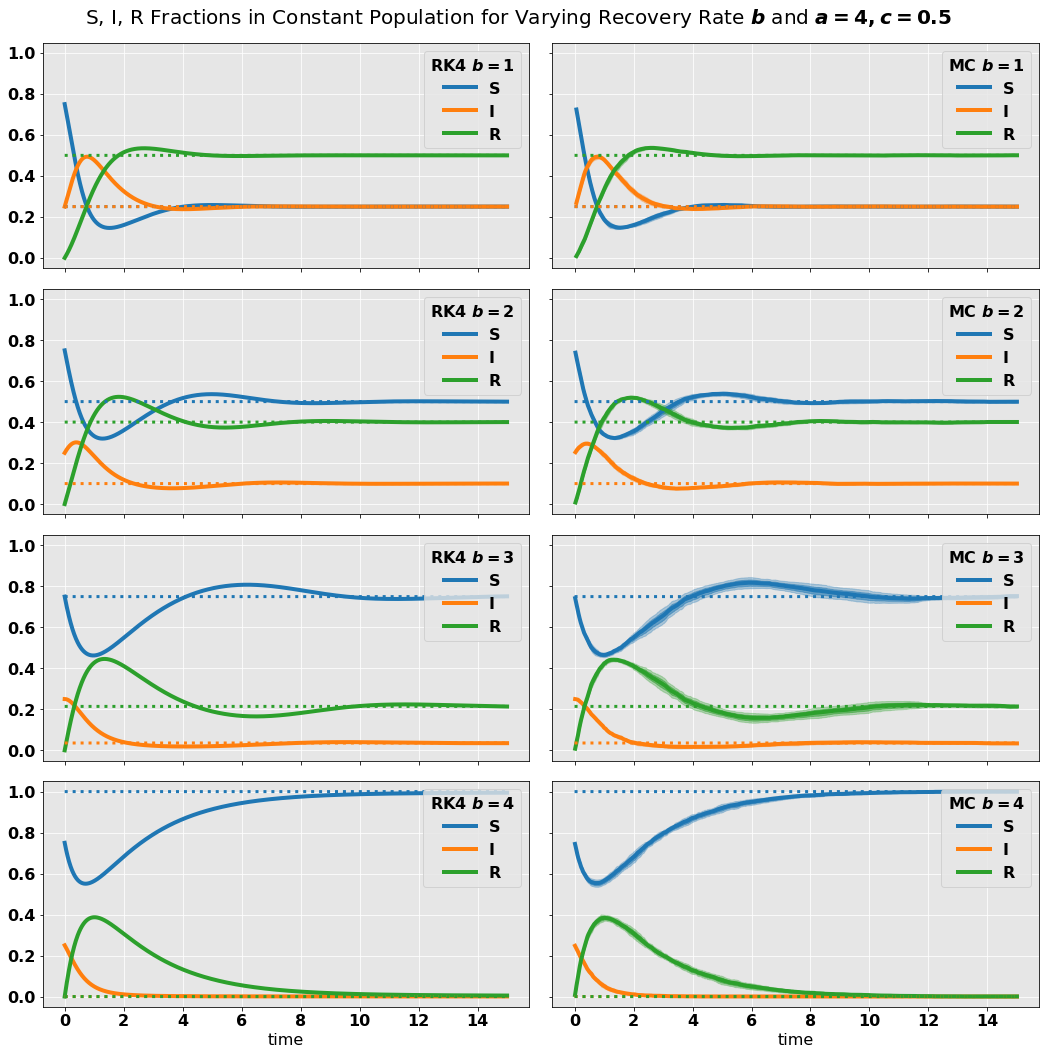

In [3]:
#%%timeit -r 1

N0 = 400
I0 = 100
a = 4
c = .5

t_end = 15
rk_steps = 100*t_end
mc_runs = 10
filter_length = 25
plot_const = True

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('S, I, R Fractions in Constant Population for Varying Recovery Rate $b$ and $a=4,c=0.5$')
ax = axes[3,0]
ax.set_xlabel('time')

ax = axes[3,1]
ax.set_xlabel('time')

for j, b in enumerate((1,2,3,4)):
    ax = axes[j,0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    S, I, R, _ = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, S)
    ax.plot(t_rk, I)
    ax.plot(t_rk, R)
    ax.legend(['S', 'I', 'R'], title=f'RK4 $b={b}$', loc='upper right')
    if plot_const:
        s, i, r = sirs.constant_fractions()
        ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
        
    ax = axes[j,1]
    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    for k, P in enumerate(['S', 'I', 'R']):
        mu, sigma = series[P]
        mu = np.convolve(mu, np.ones(filter_length)/filter_length)
        sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)
        
        mu = mu[filter_rng]
        sigma = sigma[filter_rng]
        
        t_alpha = stats.t.ppf(.995, mc_runs-1)
        upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.3)  # CI99 interval
        
        t_alpha = stats.t.ppf(.95, mc_runs-1)
        upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.5)  # CI90 interval
        
        ax.plot(t_mc, mu, color=COLORS[k])
    
    ax.legend(['S', 'I', 'R'], title=f'MC $b={b}$', loc='upper right')
    
    if plot_const:
        s, i, r = sirs.constant_fractions()
        ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
        ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
    
    print(f'(b={b}:n={len(t_mc)+filter_length}),', end=' ')
        
plt.tight_layout()
plt.show()

(dI=0.00:n=351898), (dI=0.04:n=309559), (dI=0.10:n=252640), (dI=1.00:n=69120), (dI=5.00:n=1035040), 

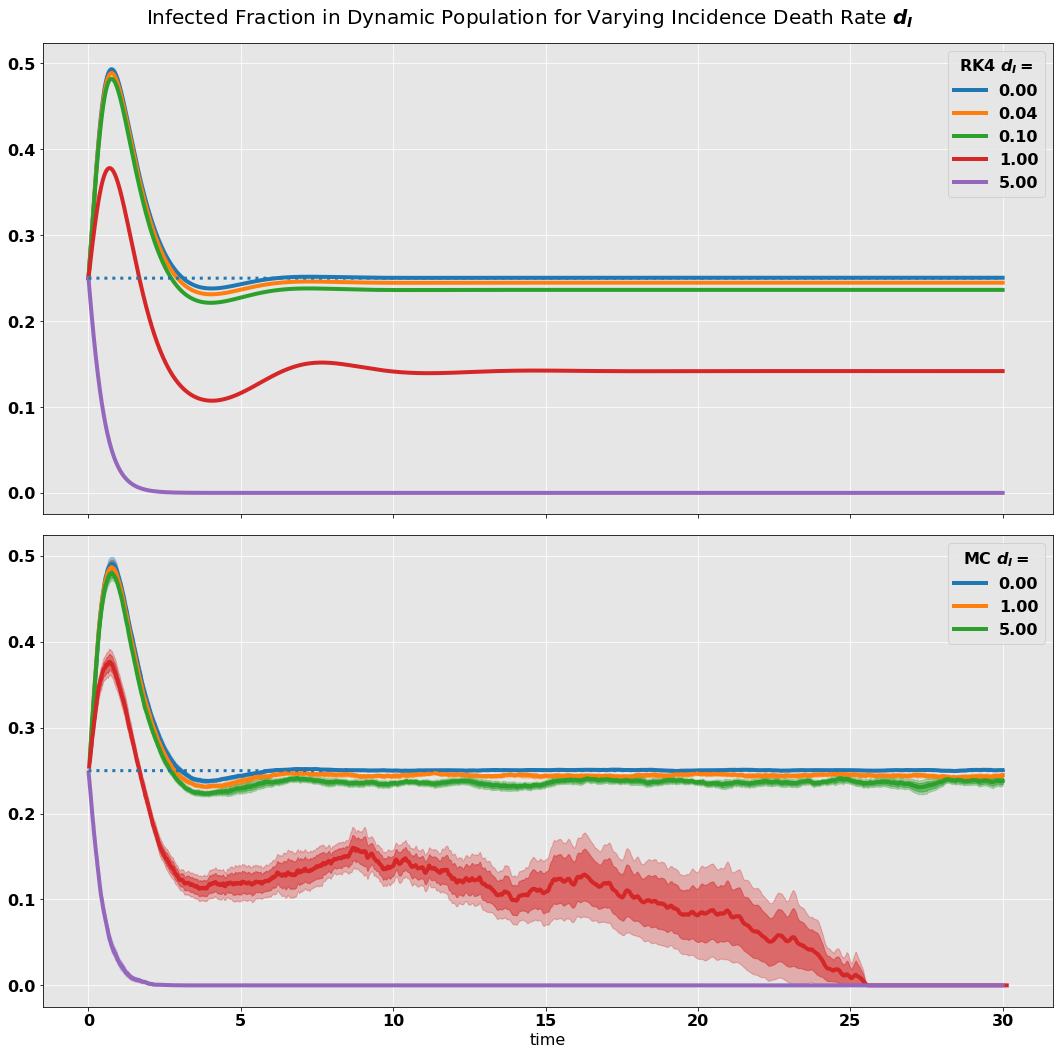

In [17]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5
d = .001
e = .002

t_end = 30
rk_steps = 100*t_end

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('Infected Fraction in Dynamic Population for Varying Incidence Death Rate $d_I$')
ax = axes[1]
ax.set_xlabel('time')

#ax = axes[3,1]
#ax.set_xlabel('time')

dI_range = np.arange(.0,3.6,.6)
dI_range = [0., 0.0401, .1, 1., 5.]

j = -1
for dI in dI_range:
    j += 1
    ax = axes[0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, N = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, I)

    ax = axes[1]

    mc_runs = 30
    filter_length = 100

    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    mu, sigma = series['I']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.995, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.3, color=COLORS[j])  # CI99 interval

    t_alpha = stats.t.ppf(.95, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5, color=COLORS[j])  # CI90 interval

    ax.plot(t_mc, mu, color=COLORS[j])
   
    print(f'(dI={dI:.2f}:n={len(t_mc)+filter_length}),', end=' ')


ax = axes[0]
_, i, _ = sirs.constant_fractions()
ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[0], lw=3)
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'RK4 $d_I=$', loc='upper right')
ax = axes[1]
ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[0], lw=3)
ax.legend([f'{dI_val:.2f}' for dI_val in [0., 1., 5.]], title=f'MC $d_I=$', loc='upper right')


plt.tight_layout()
plt.show()

(dI=0.00:n=678476), (dI=0.04:n=392178), (dI=0.10:n=208039), (dI=1.00:n=47588), (dI=5.00:n=1901158), 

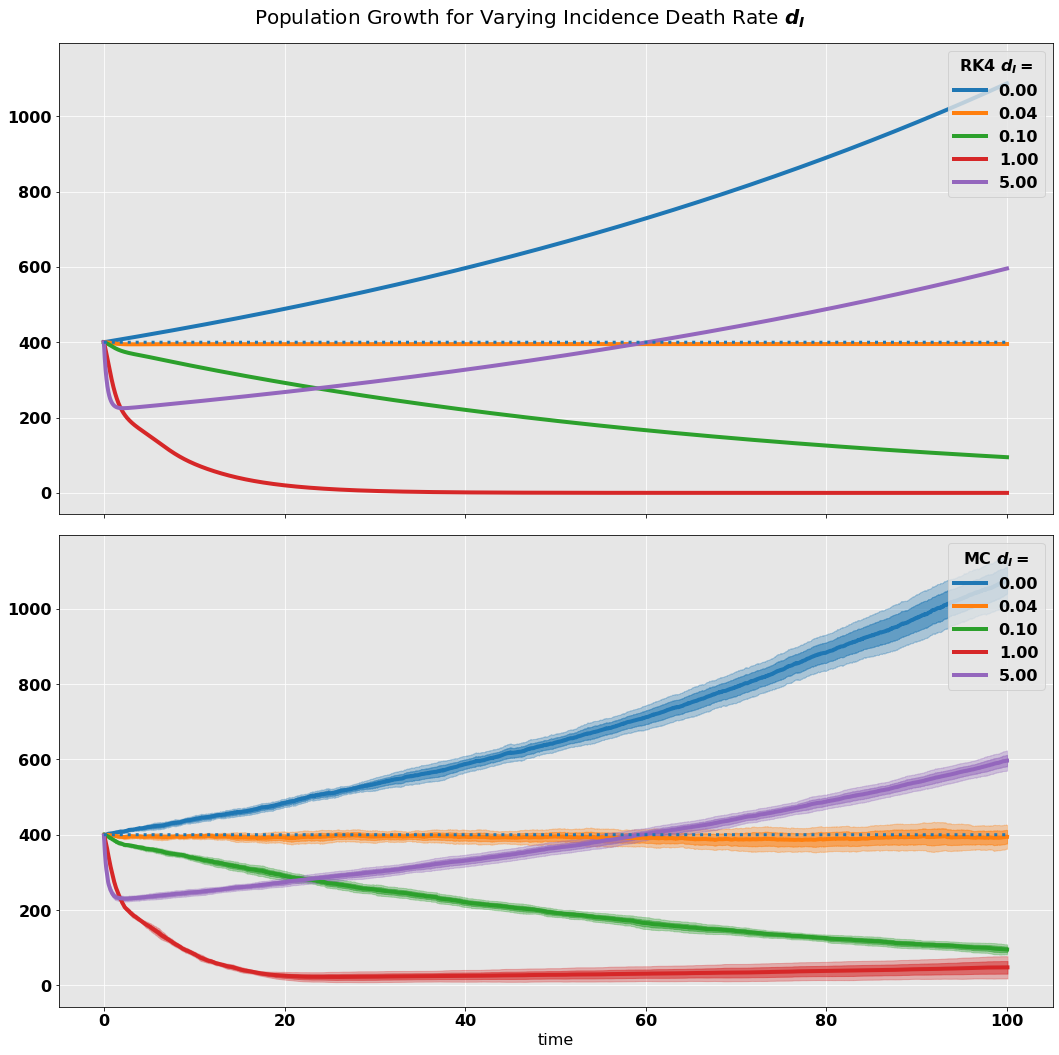

In [5]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5
d = .01
e = .02

t_end = 100
rk_steps = 100*t_end
filter_length = 1000

fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(15,15))

fig.suptitle('Population Growth for Varying Incidence Death Rate $d_I$')
ax = axes[1]
ax.set_xlabel('time')

#ax = axes[3,1]
#ax.set_xlabel('time')

dI_range = [0., 0.0401, .1, 1., 5.]

j = -1
for dI in dI_range:
    j += 1
    ax = axes[0]
    sirs = Sirs(N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, N = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, N)
    
    ax = axes[1]
   
    mc_runs = 10
    filter_length = 100
#    if dI == 1.:
#        filter_length = 1000
#        mc_runs = 100
    
    sirs_list = make_sirs_list(mc_runs, N0, I0, a=a, b=b, c=c, d=d, e=e, dI=dI)
    t_mc, series = mc_stats(sirs_list, seed=0, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]
    
    mu, sigma = series['N']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.995, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
#    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.3, color=COLORS[j])  # CI99 interval

    t_alpha = stats.t.ppf(.95, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
#    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    upper[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5, color=COLORS[j])  # CI90 interval

    ax.plot(t_mc, mu, color=COLORS[j])
   
    print(f'(dI={dI:.2f}:n={len(t_mc)+filter_length}),', end=' ')


ax = axes[0]
_, i, _ = sirs.constant_fractions()
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'RK4 $d_I=$', loc='upper right')
ax.plot(t_rk, np.zeros(rk_steps+1) + N0, ':', color=COLORS[0], lw=3)
ax = axes[1]
ax.legend([f'{dI_val:.2f}' for dI_val in dI_range], title=f'MC $d_I=$', loc='upper right')
ax.plot(t_rk, np.zeros(rk_steps+1) + N0, ':', color=COLORS[0], lw=3)

plt.tight_layout()
plt.show()

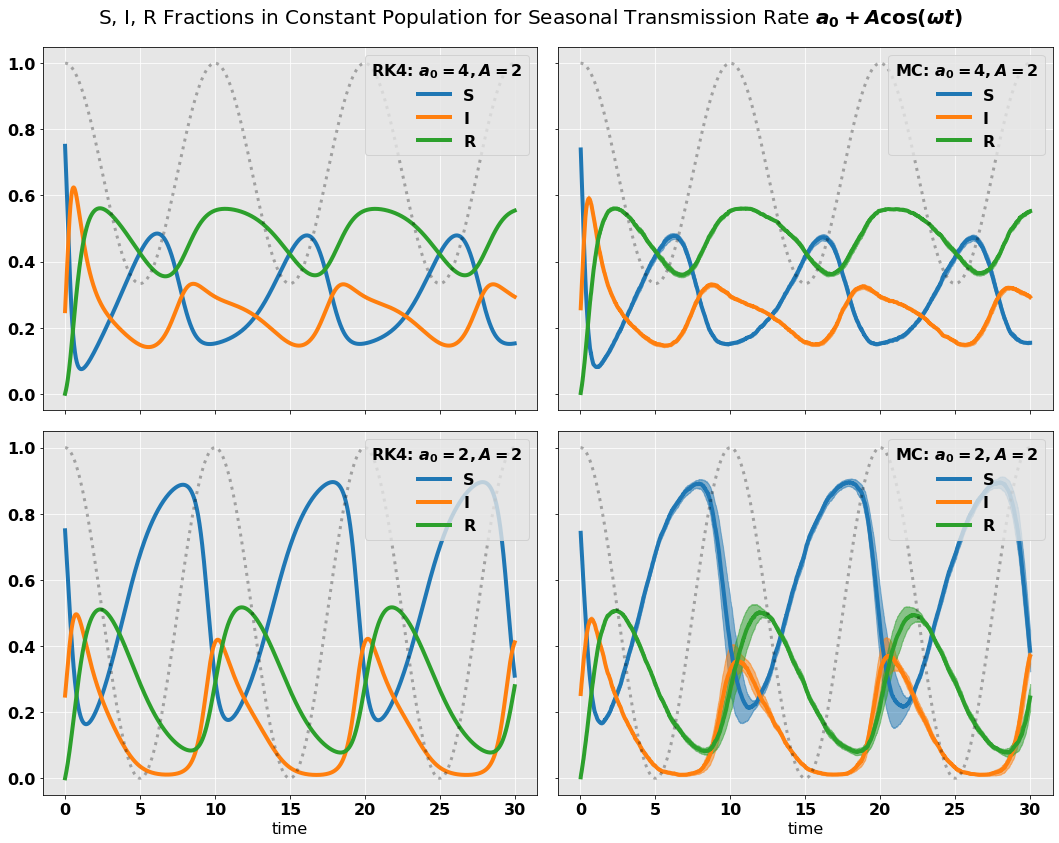

In [6]:
N0 = 400
I0 = 100
A = 2
a = 4
b = 1
c = .5


t_end = 30
mc_runs = 10
filter_length = 10



fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(15,12))
fig.suptitle('S, I, R Fractions in Constant Population for Seasonal Transmission Rate $a_0 + A \mathrm{cos} (\omega t)$')

ax = axes[1,0]
ax.set_xlabel('time')

ax = axes[1,1]
ax.set_xlabel('time')

for j, a in enumerate((4,2)):
    fa = (lambda t: a + A*np.cos(2*np.pi/10*t))
    sirs = Sirs(N0, I0, b=b, c=c, d=d, fa=fa)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end)
    S, I, R, N = solver.get_fractions()
    t_rk = solver.t

    sirs_list = make_sirs_list(mc_runs, N0, I0, b=b, c=c, d=d, fa=fa)
    t_mc, series = mc_stats(sirs_list, seed=1000, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]

    ax = axes[j,0]
    ax.plot(t_rk, S)
    ax.plot(t_rk, I)
    ax.plot(t_rk, R)
    ax.plot(t_rk, [fa(ti)/(A+a) for ti in t_rk], ':', lw=3, color='0', alpha=.3)
    ax.legend(['S', 'I', 'R'], title=f'RK4: $a_0={a},A={A}$', loc='upper right')

    ax = axes[j,1]
    for k, P in enumerate(['S', 'I', 'R']):
        mu, sigma = series[P]
        mu = np.convolve(mu, np.ones(filter_length)/filter_length)
        sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

        mu = mu[filter_rng]
        sigma = sigma[filter_rng]

        #t_alpha = stats.t.ppf(.99, mc_runs-1)
        #upper = mu + t_alpha*sigma
        #upper[upper > 1] = 1
        #lower = mu - t_alpha*sigma
        #lower[lower < 0] = 0
        #ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.3)  # CI99 interval

        t_alpha = stats.t.ppf(.95, mc_runs-1)
        upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.5)  # CI90 interval

        ax.plot(t_mc, mu, color=COLORS[k])
    ax.plot(t_rk, [fa(ti)/(A+a) for ti in t_rk], ':', lw=3, color='0', alpha=.3)
    ax.legend(['S', 'I', 'R'], title=f'MC: $a_0={a},A={A}$', loc='upper right')

plt.tight_layout()
plt.show()

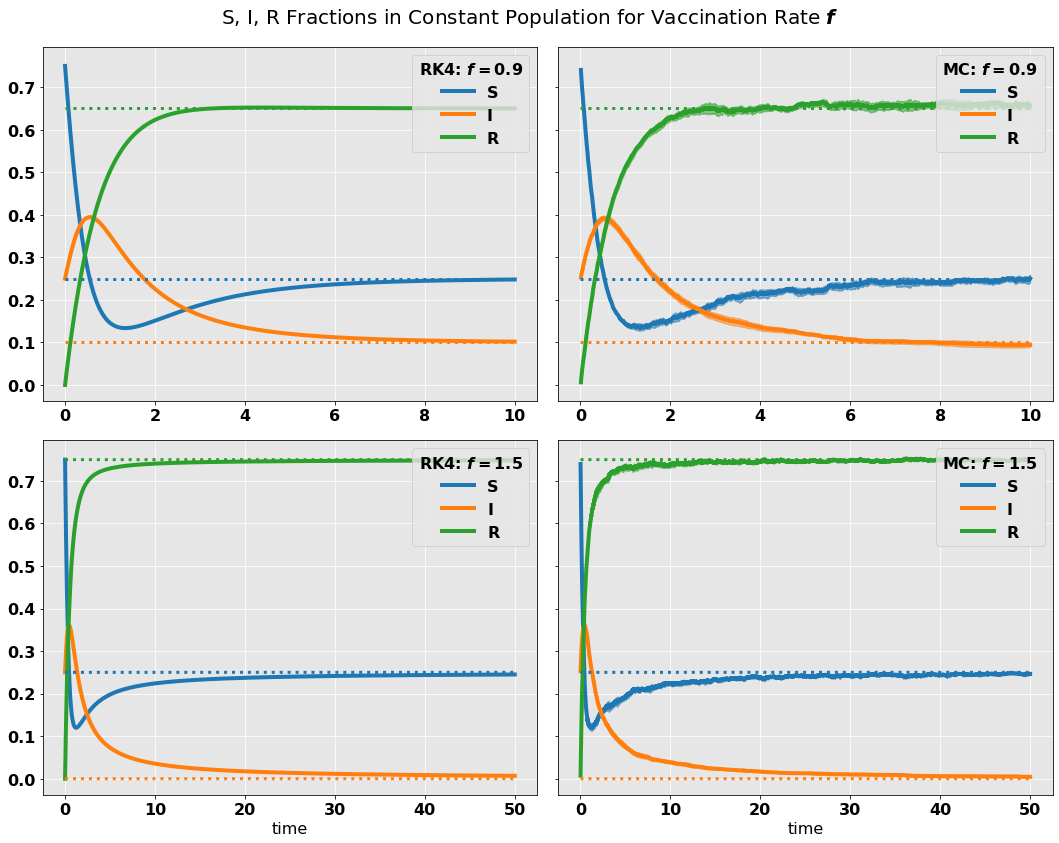

In [7]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5

mc_runs = 10
filter_length = 5

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=False, sharey=True, figsize=(15,12))
fig.suptitle('S, I, R Fractions in Constant Population for Vaccination Rate $f$')

ax = axes[1,0]
ax.set_xlabel('time')

ax = axes[1,1]
ax.set_xlabel('time')

for j, f in enumerate((.9,3/2)):
    
    if f == .9:
        t_end = 10
    if f == 3/2:
        t_end = 50
    rk_steps = t_end*100
    
    fa = (lambda t: a + A*np.cos(2*np.pi/10*t))
    sirs = Sirs(N0, I0, b=b, c=c, d=d, f=f)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    S, I, R, N = solver.get_fractions()
    t_rk = solver.t

    sirs_list = make_sirs_list(mc_runs, N0, I0, b=b, c=c, d=d, f=f)
    t_mc, series = mc_stats(sirs_list, seed=1000, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]

    ax = axes[j,0]
    ax.plot(t_rk, S)
    ax.plot(t_rk, I)
    ax.plot(t_rk, R)
    s, i, r = sirs.constant_fractions()
    ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
    ax.legend(['S', 'I', 'R'], title=f'RK4: $f={f}$', loc='upper right')

    ax = axes[j,1]
    for k, P in enumerate(['S', 'I', 'R']):
        mu, sigma = series[P]
        mu = np.convolve(mu, np.ones(filter_length)/filter_length)
        sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

        mu = mu[filter_rng]
        sigma = sigma[filter_rng]

        t_alpha = stats.t.ppf(.95, mc_runs-1)
        upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
        upper[upper > 1] = 1
        lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
        lower[lower < 0] = 0
        ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.5)  # CI90 interval

        ax.plot(t_mc, mu, color=COLORS[k])

    ax.plot(t_rk, np.zeros(rk_steps+1) + s, ':', color=COLORS[0], lw=3)
    ax.plot(t_rk, np.zeros(rk_steps+1) + i, ':', color=COLORS[1], lw=3)
    ax.plot(t_rk, np.zeros(rk_steps+1) + r, ':', color=COLORS[2], lw=3)
    ax.legend(['S', 'I', 'R'], title=f'MC: $f={f}$', loc='upper right')

plt.tight_layout()
plt.show()

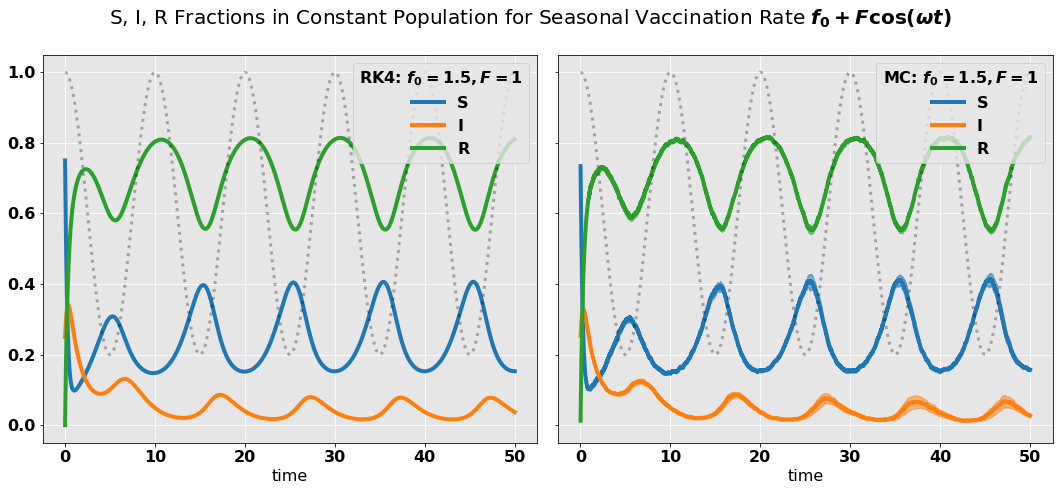

In [8]:
N0 = 400
I0 = 100
a = 4
b = 1
c = .5

f = 1.5
F = 1
ff = (lambda t: f + F*np.cos(2*np.pi/10*t))

t_end = 50
mc_runs = 10
filter_length = 10


fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(15,7))
fig.suptitle('S, I, R Fractions in Constant Population for Seasonal Vaccination Rate $f_0 + F \mathrm{cos} (\omega t)$')

ax = axes[0]
ax.set_xlabel('time')

ax = axes[1]
ax.set_xlabel('time')


sirs = Sirs(N0, I0, b=b, c=c, d=d, ff=ff)
solver = SirsSolver(sirs)
solver.run_rk4(t_end)
S, I, R, N = solver.get_fractions()
t_rk = solver.t

sirs_list = make_sirs_list(mc_runs, N0, I0, b=b, c=c, d=d, ff=ff)
t_mc, series = mc_stats(sirs_list, seed=1000, t_max=t_end)
filter_rng = np.arange(filter_length, t_mc.size)
t_mc = t_mc[filter_rng]

ax = axes[0]
ax.plot(t_rk, S)
ax.plot(t_rk, I)
ax.plot(t_rk, R)
ax.plot(t_rk, [ff(ti)/(F+f) for ti in t_rk], ':', lw=3, color='0', alpha=.3)
ax.legend(['S', 'I', 'R'], title=f'RK4: $f_0={f},F={F}$', loc='upper right')

ax = axes[1]
for k, P in enumerate(['S', 'I', 'R']):
    mu, sigma = series[P]
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.95, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, color=COLORS[k], alpha=.5)  # CI90 interval

    ax.plot(t_mc, mu, color=COLORS[k])
ax.plot(t_rk, [ff(ti)/(F+f) for ti in t_rk], ':', lw=3, color='0', alpha=.3)
ax.legend(['S', 'I', 'R'], title=f'MC: $f_0={f},F={F}$', loc='upper right')

plt.tight_layout()
plt.show()

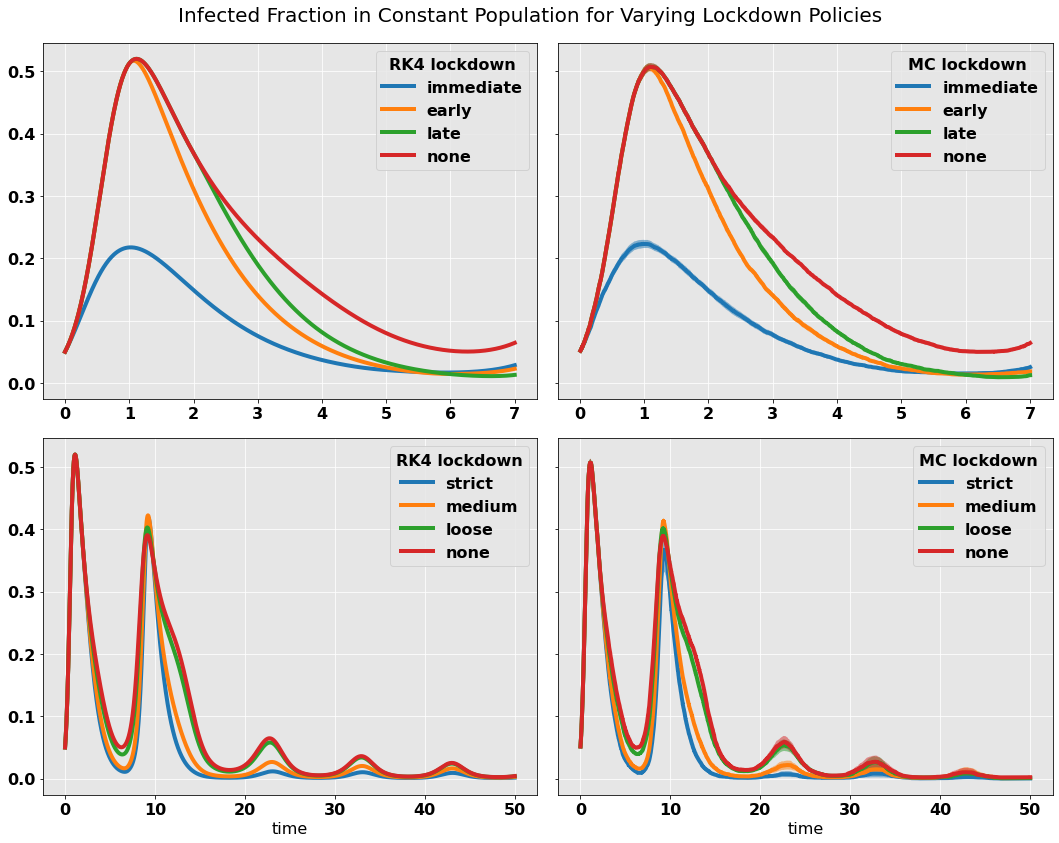

In [9]:
N0 = 400
I0 = 20
b = 1
c = .5

a0 = 3
A0 = .75*a0


fa0 = (lambda t: (bathtub(t, .5, floor=.1, delay=0, duration=5)+bathtub(t, .5, floor=.3, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa1 = (lambda t: (bathtub(t, .5, floor=.1, delay=1, duration=5)+bathtub(t, .5, floor=.8, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa2 = (lambda t: (bathtub(t, .5, floor=.1, delay=2, duration=5)+bathtub(t, .5, floor=1.0, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa3 = (lambda t: seasonal_variation(t, a=a0, A=A0, shift=0))
first_lock_down = (fa0, fa1, fa2, fa3)
first_lock_down_names = ('immediate', 'early', 'late', 'none')

fa0 = (lambda t: (bathtub(t, .5, floor=.1, delay=2, duration=5)+bathtub(t, .5, floor=.1, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa1 = (lambda t: (bathtub(t, .5, floor=.3, delay=2, duration=5)+bathtub(t, .5, floor=.3, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa2 = (lambda t: (bathtub(t, .5, floor=.8, delay=2, duration=5)+bathtub(t, .5, floor=.8, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa3 = (lambda t: seasonal_variation(t, a=a0, A=A0, shift=0))
second_lock_down = (fa0, fa1, fa2, fa3)
second_lock_down_names = ('strict', 'medium', 'loose', 'none')

f1 = 1
F1 = .5*f1
ff1 = (lambda t: exponential_growth(t, 1.0, floor=0, delay=15)*seasonal_variation(t, a=f1, A=F1, shift=-2.5))


mc_runs = 25
filter_length = 10

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=False, sharey=True, figsize=(15,12))
fig.suptitle('Infected Fraction in Constant Population for Varying Lockdown Policies')

t_end = 7
rk_steps = t_end*100

for fa in first_lock_down:
    ax = axes[0,0]
    sirs = Sirs(N0, I0, b=b, c=c, d=d, fa=fa, ff=ff1)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, _ = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, I)

    
    ax = axes[0,1]
    sirs_list = make_sirs_list(mc_runs, N0, I0, b=b, c=c, d=d, fa=fa, ff=ff1)
    t_mc, series = mc_stats(sirs_list, seed=1000, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]

    mu, sigma = series['I']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.95, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5)  # CI90 interval
    ax.plot(t_mc, mu)
    
    
t_end = 50
rk_steps = t_end*100

for fa in second_lock_down:
    ax = axes[1,0]
    sirs = Sirs(N0, I0, b=b, c=c, d=d, fa=fa, ff=ff1)
    solver = SirsSolver(sirs)
    solver.run_rk4(t_end, rk_steps)
    _, I, _, _ = solver.get_fractions()
    t_rk = solver.t
    ax.plot(t_rk, I)

    
    ax = axes[1,1]
    sirs_list = make_sirs_list(mc_runs, N0, I0, b=b, c=c, d=d, fa=fa, ff=ff1)
    t_mc, series = mc_stats(sirs_list, seed=1000, t_max=t_end)
    filter_rng = np.arange(filter_length, t_mc.size)
    t_mc = t_mc[filter_rng]

    mu, sigma = series['I']
    mu = np.convolve(mu, np.ones(filter_length)/filter_length)
    sigma = np.convolve(sigma, np.ones(filter_length)/filter_length)

    mu = mu[filter_rng]
    sigma = sigma[filter_rng]

    t_alpha = stats.t.ppf(.95, mc_runs-1)
    upper = mu + t_alpha*sigma/np.sqrt(mc_runs)
    upper[upper > 1] = 1
    lower = mu - t_alpha*sigma/np.sqrt(mc_runs)
    lower[lower < 0] = 0
    ax.fill_between(t_mc, lower, upper, alpha=.5)  # CI90 interval
    ax.plot(t_mc, mu)


ax = axes[0,0]
ax.legend(first_lock_down_names, title=f'RK4 lockdown', loc='upper right')

ax = axes[0,1]
ax.legend(first_lock_down_names, title=f'MC lockdown', loc='upper right')

ax = axes[1,0]
ax.legend(second_lock_down_names, title=f'RK4 lockdown', loc='upper right')

ax = axes[1,1]
ax.legend(second_lock_down_names, title=f'MC lockdown', loc='upper right')
       
ax = axes[1,0]
ax.set_xlabel('time')

ax = axes[1,1]
ax.set_xlabel('time')

plt.tight_layout()
plt.show()

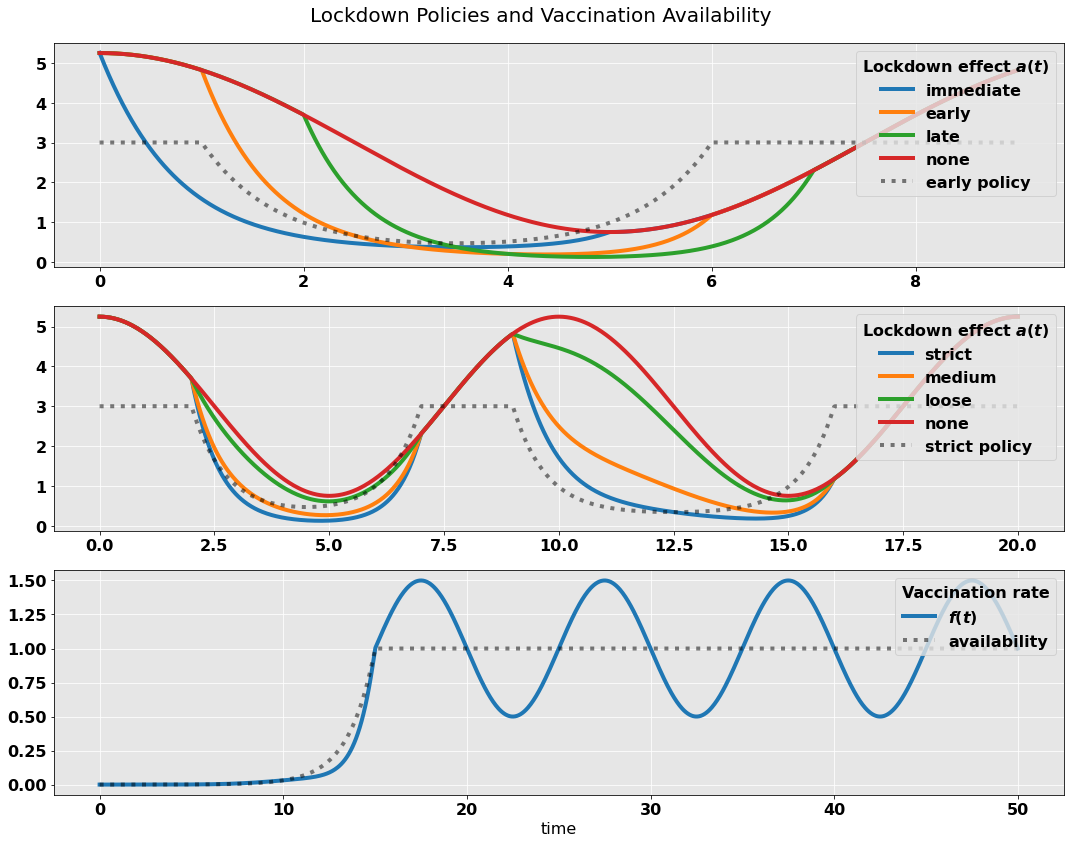

In [10]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=False, sharey=False, figsize=(15,12))
fig.suptitle('Lockdown Policies and Vaccination Availability')

ax = axes[0]
t = np.linspace(0,9,1000)
first_lock_down_names = ['immediate', 'early', 'late', 'none']
fa0 = (lambda t: (bathtub(t, .5, floor=.1, delay=0, duration=5)+bathtub(t, .5, floor=.3, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa1 = (lambda t: (bathtub(t, .5, floor=.1, delay=1, duration=5)+bathtub(t, .5, floor=.8, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa2 = (lambda t: (bathtub(t, .5, floor=.1, delay=2, duration=5)+bathtub(t, .5, floor=1.0, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa3 = (lambda t: seasonal_variation(t, a=a0, A=A0, shift=0))
first_lock_down = (fa0, fa1, fa2, fa3)
for fa in first_lock_down:
    ax.plot(t, [fa(ti) for ti in t])

fa = (lambda t: a0*(bathtub(t, .5, floor=.1, delay=1, duration=5)+bathtub(t, .5, floor=1.0, delay=9, duration=7)-1))
ax.plot(t, [fa(ti) for ti in t], ':', color='0', alpha=.5)
    
ax = axes[1]
t = np.linspace(0,20,1000)
second_lock_down_names = ['strict', 'medium', 'loose', 'none']
fa0 = (lambda t: (bathtub(t, .5, floor=.1, delay=2, duration=5)+bathtub(t, .5, floor=.1, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa1 = (lambda t: (bathtub(t, .5, floor=.3, delay=2, duration=5)+bathtub(t, .5, floor=.3, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa2 = (lambda t: (bathtub(t, .5, floor=.8, delay=2, duration=5)+bathtub(t, .5, floor=.8, delay=9, duration=7)-1)*seasonal_variation(t, a=a0, A=A0, shift=0))
fa3 = (lambda t: seasonal_variation(t, a=a0, A=A0, shift=0))
second_lock_down = (fa0, fa1, fa2, fa3)
for fa in second_lock_down:
    ax.plot(t, [fa(ti) for ti in t])

fa = (lambda t: a0*(bathtub(t, .5, floor=.1, delay=2, duration=5)+bathtub(t, .5, floor=.1, delay=9, duration=7)-1))
ax.plot(t, [fa(ti) for ti in t], ':', color='0', alpha=.5)


ax = axes[2]
t = np.linspace(0,50,1000)
ff = (lambda t: exponential_growth(t, 1.0, floor=0, delay=15)*seasonal_variation(t, a=f1, A=F1, shift=-2.5))
ax.plot(t, [ff(ti) for ti in t])
ff = (lambda t: f1*exponential_growth(t, 1.0, floor=0, delay=15))
ax.plot(t, [ff(ti) for ti in t], ':', color='0', alpha=.5)

ax = axes[0]
ax.legend(first_lock_down_names+['early policy'], title=f'Lockdown effect $a(t)$', loc='upper right')

ax = axes[1]
ax.legend(second_lock_down_names+['strict policy'], title=f'Lockdown effect $a(t)$', loc='upper right')

ax = axes[2]
ax.set_xlabel('time')
ax.legend(['$f(t)$', 'availability'], title=f'Vaccination rate', loc='upper right')

plt.tight_layout()
plt.show()

In [11]:
N0 = 400
I0 = 100
a = 4
b = 3
c = .5
e = .0
d = .0
dI = .0
F = .0
f = .1
sirs = Sirs(N0, I0, a=a, b=b, c=c)
solver = SirsSolver(sirs)
solver.run_mc(t_max=10000)

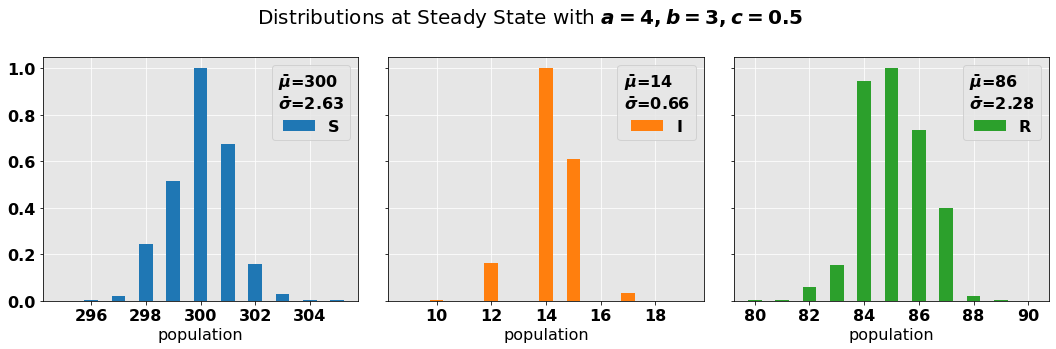

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=True, figsize=(15,5))
fig.suptitle('Distributions at Steady State with $a=4,b=3,c=0.5$')

stats, (S,I,R,N) = solver.get_stats(10)

for i, (code, pop) in enumerate([('S', S), ('I', I), ('R', R)]):
    ax = axes[i]
    mu, sigma = stats[code]
    y, x = np.histogram(pop, bins=11, range=(mu-5*sigma, mu+5*sigma))
    ax.bar(np.arange(-5,6)+int(mu), y/y.max(), width=.5, align='center', color=COLORS[i])
    ax.legend([code], title=r'$\bar{\mu}$' + f'={mu:.0f}' + '\n' + r'$\bar{\sigma}$' + f'={sigma:.2f}')
    ax.set_xlabel('population')

plt.tight_layout()
plt.show()